## Initialize main variables and set up environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install pydicom
!pip install tensorflow_addons

     |████████████████████████████████| 35.3MB 94kB/s 


In [1]:
import os
base_dir = '/content/drive/My Drive/'
dsb_dir = base_dir + 'dsb2018_topcoders/'
selim_dir = dsb_dir + 'selim/'
os.chdir(dsb_dir)
!git config --global user.email "tilacyn@yandex.ru"
!git config --global user.name "Maksim Kryuchkov"
!git add '/content/drive/My Drive/dsb2018_topcoders/selim/ipynb'
!git commit -m "updated ipynb files"
!git pull

[master a476d1d] updated ipynb files
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/tilacyn/dsb2018_topcoders
   1ab180e..91bf28f  master     -> origin/master
hint: Waiting for your editor to close the file... error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [2]:
import os

base_dir = '/content/drive/My Drive/'
dsb_dir = base_dir + 'dsb2018_topcoders/'
selim_dir = dsb_dir + 'selim/'

os.chdir(selim_dir)

from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
import tensorflow
import tensorflow.keras.backend as K
from datasets.lidc import LIDCDatasetIterator, LIDCTestDatasetIterator
from models.model_factory import make_model
from losses import make_loss
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.python.client import device_lib
from os.path import join as opjoin
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib import pyplot as plt
from models.model_factory import make_model
from datasets.lidc import imread
from os import path, mkdir, listdir
import timeit
import cv2
from tqdm import tqdm
import numpy as np
from zipfile import ZipFile
from datasets.lidc import imread, parseXML, make_mask
from sklearn.metrics import recall_score
from train_data import MODELS_JSON, TrainData, from_dict, models_json_file
import json

nn_models_dir = opjoin(selim_dir, 'nn_models')


Using TensorFlow backend.


## Define functions used for testing trained models 



In [0]:
# os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

def get_n_child(parent, n):
    return os.path.join(parent, os.listdir(parent)[n])


def walk():
    data_folder = os.path.join(dsb_dir, 'data')
    # test_folder = get_n_child(get_n_child(get_n_child(data_folder, 5), 0), 0)
    # print('test folder: {}'.format(test_folder))

    models = ['lidc_xception_fpn_checkpoint.h5']
    network = 'xception_fpn'
    out_root_dir = '../predictions'
    models_dir = os.path.join(dsb_dir, 'selim/nn_models')
    t0 = timeit.default_timer()

    weights = [os.path.join(models_dir, m) for m in models]
    models = []
    for w in weights:
        model = make_model(network, (None, None, 3))
        print("Building model {} from weights {} ".format(network, w))
        model.load_weights(w)
        models.append(model)
    print('Predicting test')
    
    for root, folders, files in os.walk(data_folder):
        for file in files:
            if file.endswith('dcm'):
                print(os.path.join(data_folder, root, file))
                image = imread(os.path.join(data_folder, root, file))[0]
                image = np.reshape(image, (image.shape[0], image.shape[1], 1))
                image = np.repeat(image, 3, axis=2)
                pred = None
                try:
                    pred = models[0].predict(np.array([image], 'float32'), batch_size=1)
                except:
                    print("exception occurred")
                if pred is None:
                  continue
                if np.any(pred > 0.01):
                  print("SUCCESS")
                  plt.imshow(pred[0, :, :, 0])
                  plt.axis('off')
                  plt.show()
                  return

def run():
    # test_folder = os.path.join(dsb_dir, 'data/LIDC-IDRI-0787/01-01-2000-53104/30821-77077')
    data_folder = os.path.join(dsb_dir, 'data')
    test_folder = get_n_child(get_n_child(get_n_child(data_folder, 5), 0), 0)
    print('test folder: {}'.format(test_folder))

    models = ['xception_fpn.h5']
    network = 'xception_fpn'
    out_root_dir = '../predictions'
    models_dir = os.path.join(dsb_dir, 'selim/nn_models')
    t0 = timeit.default_timer()

    weights = [os.path.join(models_dir, m) for m in models]
    models = []
    for w in weights:
        model = make_model(network, (None, None, 3))
        print("Building model {} from weights {} ".format(network, w))
        model.load_weights(w)
        models.append(model)
    print('Predicting test')
    for d in tqdm(listdir(test_folder)[:10]):
        # if '000071.dcm' not in d:
        #     continue
        print('processing {}'.format(d))
        image = imread(test_folder + '/' + d)[0]
        image = np.reshape(image, (image.shape[0], image.shape[1], 1))
        image = np.repeat(image, 3, axis=2)
                    

        pred = models[0].predict(np.array([image], 'float32'), batch_size=1)
        pred = pred * 240
        print(pred.shape)
        cv2.imwrite(os.path.join(out_root_dir, d + '.jpg'), pred[0,:,:,0])
        plt.imshow(pred[0, :, :, 0])
        plt.axis('off')
        plt.show()

    elapsed = timeit.default_timer() - t0
    print('Time: {:.3f} min'.format(elapsed / 60))

In [0]:
# image = cv2.imread('/content/drive/My Drive/dsb2018_topcoders/mrt/screen.png')

im_root = '/content/drive/My Drive/dsb2018_topcoders/data/LIDC-IDRI-0796/01-01-2000-CT GUIDED LUNG B-69712/2-17499'

image, _ = imread(opjoin(im_root, '000036.dcm'))
# print(image.shape)
image = cv2.resize(image, (256, 256))
image = np.reshape(image, (256, 256, 1))
image = np.repeat(image, 3, axis=2)
print(image.shape)
pred = model.predict(np.array([image]), batch_size=1)
plt.axis('off')
plt.imshow(pred[0, :, :, 0])

# plt.imshow(image)
# plt.imshow(np.full((256, 256), ))
# plt.imshow(pred[0, :, :, 1])
plt.show()

## Test class

In [0]:


def dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    divisor = np.sum(y_true) + np.sum(y_pred)
    if divisor == 0:
      return 1
    return 2 * intersection / divisor


def pad(image):
    return np.pad(image, ((0, 0), (0, 2)), constant_values=1)

def sens(y_true, y_pred):
    if dice(y_true, y_pred) > 0 and y_true.max() > 0:
      return 1, 1
    elif y_true.max() > 0:
      return 0, 1
    return 0, 0

def spec(y_true, y_pred):
    if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
      return 1, 1
    elif np.sum(y_true) == 0:
      return 0, 1
    return 0, 0

class Test:
    def __init__(self, nn_models_dir, predict_threshold):
        self.nn_models_dir = nn_models_dir
        self.predict_threshold = predict_threshold

    def calculate_metrics_for_model(self, model, gen):
        dice_coefficients = []
        tp = 0
        p = 0
        tn = 0
        n = 0
        confusion_matrix = np.zeros([2, 2])
        for _ in range(10):
            batch = next(gen())
            x, y = batch
            for i in range(len(x)):
              image, image_parts = x[i]
              mask, mask_parts = y[i]
              image_parts = np.array(image_parts)
              image_parts = image_parts.reshape(16, 16, 256, 256, 3)

              pred_parts = np.array([model.predict(sub_part, batch_size=16) for sub_part in image_parts])
              pred_parts = pred_parts.reshape(16, 16, 256, 256).swapaxes(1, 2).reshape(16 * 256, 16 * 256)
              pred = cv2.resize(pred_parts, (256, 256))
              pred = pred > self.predict_threshold
              dice_coefficients.append(dice(mask, pred))
              tp_inc, p_inc = sens(mask, pred)
              tn_inc, n_inc = spec(mask, pred)
              tp += tp_inc
              tn += tn_inc
              p += p_inc
              n += n_inc
        print('tp / p {} {}'.format(tp, p))
        print('tn / n {} {}'.format(tn, n))
        return np.mean(dice_coefficients), (tp / p), (tn / n)

    def calculate_metrics_for_td(self, td, gen):
        if td.metric_eval_timestamp == 'kek':
            return td
        else:
            model = make_model(td.model_name, (None, None, 3))
            model.load_weights(opjoin(self.nn_models_dir, td.model_file_name))
            dice_c, sens_c, spec_c = self.calculate_metrics_for_model(model, gen)
            td.add_metrics(dice=dice_c, recall=sens_c, spec=spec_c)

            return td

    def visualize_for_train_data(self, td, gen, number_to_show=4):
        model = make_model(td.model_name, (None, None, 3))
        model.load_weights(opjoin(self.nn_models_dir, td.model_file_name))
        batch = next(gen())
        x, y = batch
        print(x)
        for i in range(number_to_show):
            image, image_parts = x[i]
            mask, mask_parts = y[i]
            image_parts = np.array(image_parts)
            image_parts = image_parts.reshape(16, 16, 256, 256, 3)

            pred_parts = np.array([model.predict(sub_part, batch_size=16) for sub_part in image_parts])
            pred_parts = pred_parts.reshape(16, 16, 256, 256).swapaxes(1, 2).reshape(16 * 256, 16 * 256)
            pred_parts = cv2.resize(pred_parts, (256, 256))
            show(image, mask, pred_parts, self.predict_threshold)

def show(x, y, pred, predict_threshold):
    expected = np.reshape(y, (256, 256))
    actual = np.reshape(pred, (256, 256))

    x_to_show = x[:, :, 0]
    x_to_show = x_to_show / x_to_show.max()

    actual = actual > predict_threshold

    to_show = np.array([pad(x_to_show), pad(actual), pad(expected)])
    to_show = np.hstack(to_show.reshape(3, 256, 258))

    print(to_show.shape)
    # to_show = cv2.resize(to_show, (3 * 258 * 3, 256 * 3))

    plt.imshow(to_show)
    plt.show()

    print('\n===============')
    print('===============\n')


In [44]:
with open(models_json_file, "r") as read_file:
    records = json.load(read_file)

tds = [from_dict(r) for r in records]

td = tds[-1]
# records = [tdi.to_dict() for ]
ds = LIDCTestDatasetIterator(opjoin(dsb_dir, 'data'), 16, td.test_index_list, 0, (256, 256), 16)
# print('ds.test_index_list')
# print(td.test_index_list)


# with open(models_json_file, "w") as write_file:
#     json.dump(records, write_file, indent=1)

112it [00:00, 600.12it/s] 

total len: 12226
train index array: 12226
val index array: 0


In [47]:
result = []
for thr in [0.4, 0.45, 0.5]:
  test = Test(nn_models_dir, thr)
  test.calculate_metrics_for_td(td, gen)
  result.append([td.dice_coefficient, td.recall, td.spec])

[11386, 3048, 815, 4007, 4742, 2629, 1707, 6599]
[2956, 7096, 3363, 319, 11570, 567, 6240, 3518]
[5384, 8202, 6483, 1946, 10213, 9996, 7606, 659]
[9919, 6902, 6898, 371, 12070, 11532, 6577, 8334]
[5150, 8972, 4130, 683, 2582, 4703, 12193, 10838]
[12199, 4844, 6156, 2649, 3934, 7944, 5299, 5114]
[250, 8921, 1153, 4754, 5939, 2396, 9818, 9627]
[7761, 4624, 11927, 4947, 10242, 7583, 6007, 4885]
[7077, 4929, 4778, 6966, 3169, 6556, 2969, 12050]
[9509, 4753, 6543, 11335, 3456, 8770, 444, 11400]
tp / p 14 90
tn / n 2 70
[5276, 1098, 792, 6584, 3039, 118, 8483, 11768]
[4772, 6245, 11458, 8040, 7116, 5677, 7402, 10636]
[1262, 970, 12130, 1207, 1551, 7111, 2656, 9803]
[5544, 6491, 11997, 5051, 4998, 8223, 12174, 2398]
[2554, 4025, 56, 9296, 9777, 2382, 7580, 11705]
[6527, 4288, 6564, 2611, 4701, 5159, 3755, 6328]
[6029, 1833, 5737, 3760, 1050, 11295, 5390, 11139]
[4300, 5931, 1518, 9556, 10119, 7293, 1213, 12134]
[8493, 8759, 8511, 11563, 2146, 1859, 1079, 8925]
[9297, 816, 8662, 1299, 1436, 38

In [43]:
# result_for_first
# result = []

[[0.15631707443179368, 0.4090909090909091, 0.027777777777777776],
 [0.08405526162079277, 0.19540229885057472, 0.0547945205479452],
 [0.10519340866302543, 0.1927710843373494, 0.09090909090909091],
 [0.4625, 0.0, 0.9866666666666667]]

[2638, 9126, 3130, 3236, 10870, 7737, 10384, 9082]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(256, 774)


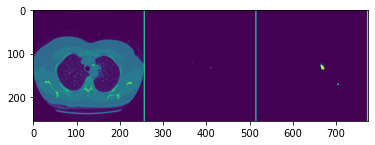



(256, 774)


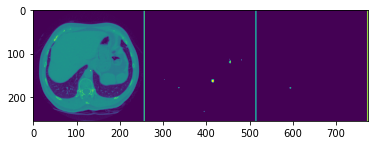



(256, 774)


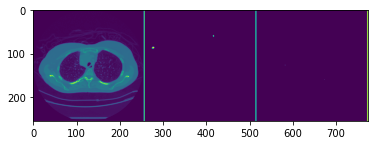



(256, 774)


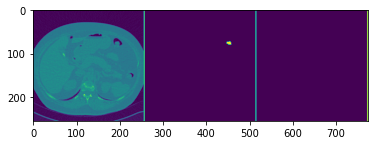

In [46]:
test = Test(nn_models_dir, 0.4)
gen = ds.test_generator()
test.visualize_for_train_data(td, gen)
# np.random.choice(np.array(ds.all_images))

## Results

In [48]:
thrs = [0.4, 0.45, 0.5, 0.55]

with open(models_json_file, "r") as read_file:
    records = json.load(read_file)

td_first = from_dict(records[-2])


for i in range(4):
  print('Predict threshold: {}'.format(thrs[i]), end='')
  print('dice: {}, sensitivity : {}, specificity : {}'.format(result_for_first[i][0], result_for_first[i][1], result_for_first[i][2]))

Predict threshold: 0.4dice: 0.15631707443179368, sensitivity : 0.4090909090909091, specificity : 0.027777777777777776
Predict threshold: 0.45dice: 0.08405526162079277, sensitivity : 0.19540229885057472, specificity : 0.0547945205479452
Predict threshold: 0.5dice: 0.10519340866302543, sensitivity : 0.1927710843373494, specificity : 0.09090909090909091
Predict threshold: 0.55dice: 0.4625, sensitivity : 0.0, specificity : 0.9866666666666667


In [13]:
models_json_file = opjoin(nn_models_dir, MODELS_JSON)

with open(models_json_file, "r") as read_file:
    records = json.load(read_file)

tds = [from_dict(r, nn_models_dir) for r in records]

test = Test(nn_models_dir, 0.9)

# test.visualize_for_train_data(tds[-3], batches[0], number_to_show=8)

for td in tds:
  print('processing td:')
  print(td.to_dict())
  print('\n\n')
  if td.grid_size != 16:
    continue
  test.calculate_metrics_for_td(td, gen)

records = [tdi.to_dict() for tdi in tds]

with open(models_json_file, "w") as write_file:
    records = json.dump(records, write_file, indent=1)



processing td:
{'Model Name': 'xception_fpn', 'Epochs': 6, 'Loss': None, 'Loss Value': None, 'Validation Dataset Length': 200, 'Validation Steps': 24, 'Grid Size': 16, 'Recall': None, 'Specificity': None, 'Dice Coefficient': 0.0732588756315552, 'Training Finished at': '2020-04-08 19:10:28.619474', 'Metrics Calculated at': '2020-04-09 22:09:26.398292', 'Model Filename': 'xception_fpn_6_16_vahqhbangi.h5'}



processing td:
{'Model Name': 'xception_fpn', 'Epochs': 6, 'Loss': None, 'Loss Value': None, 'Validation Dataset Length': 400, 'Validation Steps': 48, 'Grid Size': 16, 'Recall': None, 'Specificity': None, 'Dice Coefficient': 0.061950443894355806, 'Training Finished at': '2020-04-08 19:41:54.531071', 'Metrics Calculated at': '2020-04-09 22:09:42.947035', 'Model Filename': 'xception_fpn_6_16_nhkflsuhqe.h5'}



processing td:
{'Model Name': 'xception_fpn', 'Epochs': 15, 'Loss': None, 'Loss Value': None, 'Validation Dataset Length': 640, 'Validation Steps': 80, 'Grid Size': 16, 'Recall':

In [0]:
records = [tdi.to_dict() for tdi in tds]

with open(models_json_file, "w") as write_file:
    records = json.dump(records, write_file, indent=1)

## Run tests

In [1]:
# batches = [next(gen()) for i in range(1)]
for batch in batches:
  x, y = batch
  pred = model.predict(x, batch_size=16)
  for i in range(len(pred)):
    expected = np.reshape(y[i], (256, 256))
    actual = np.reshape(pred[i], (256, 256))

    print('original:')

    plt.imshow(x[i])
    plt.show()

    print('actual:')
    plt.imshow(actual)
    plt.show()

    print('expected:')
    plt.imshow(expected)
    plt.show()

    print('\n===============')
    print('===============\n')

NameError: ignored

0.6953125
0.835820895522388


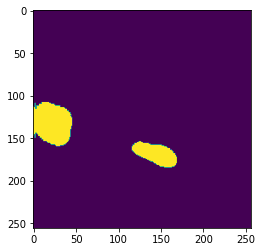

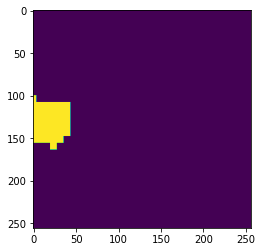

0.984375
0.0


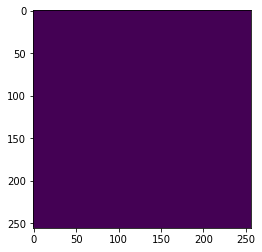

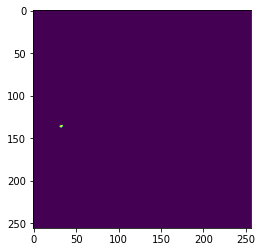

0.4453125
0.31026785714285715


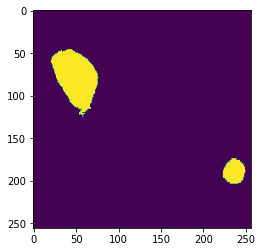

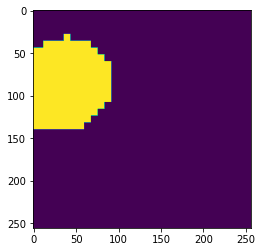

0.9609375
0.0


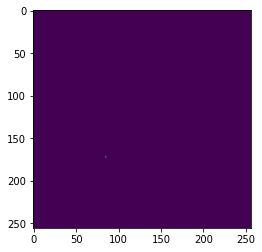

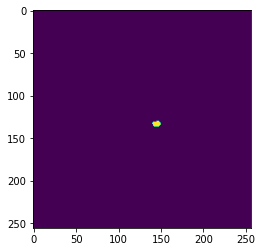

0.79296875
0.0


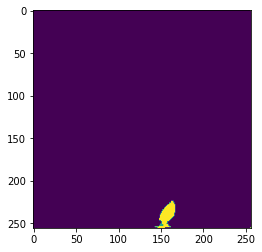

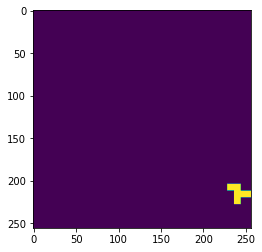

0.98828125
0.0


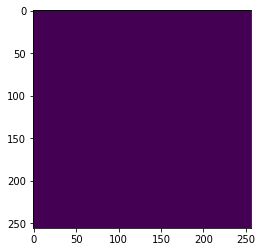

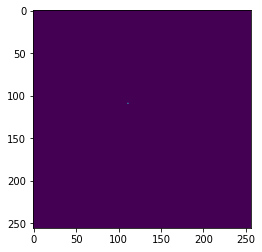

0.90625
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


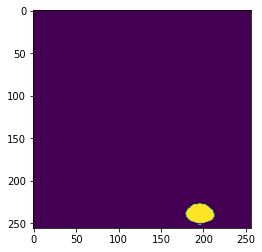

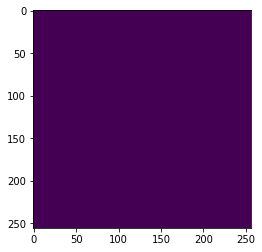

0.99609375
0.0


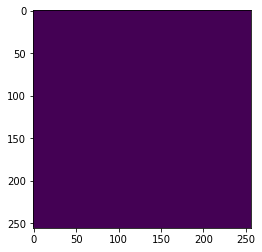

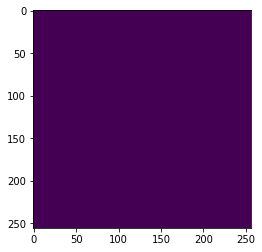

0.8125
0.67109375


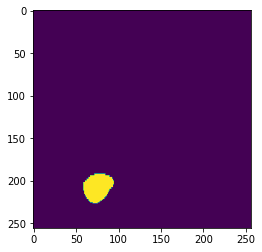

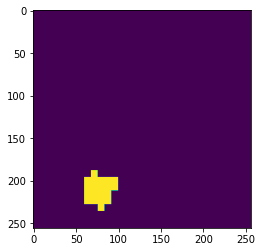

0.95703125
0.0


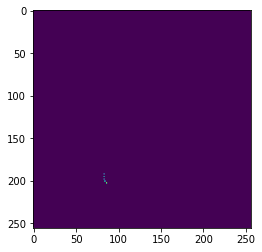

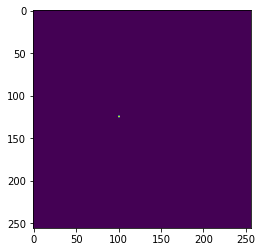

0.10546875
0.7534246575342466


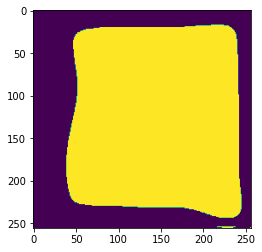

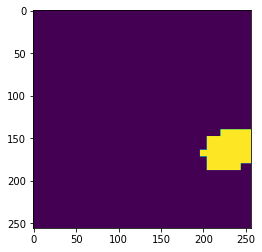

0.9453125
0.0


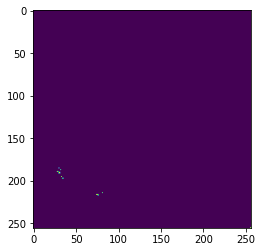

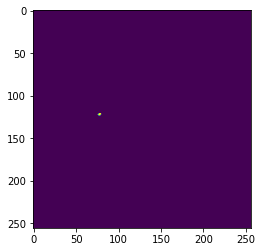

0.765625
0.854326923076923


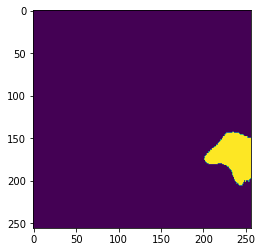

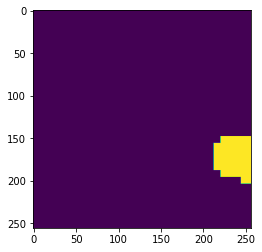

0.98046875
0.0


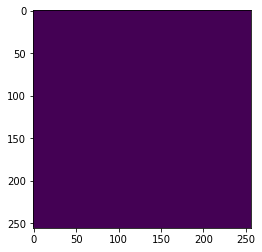

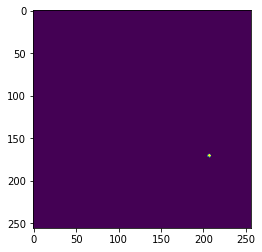

0.734375
0.34422709923664124


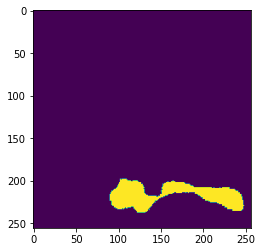

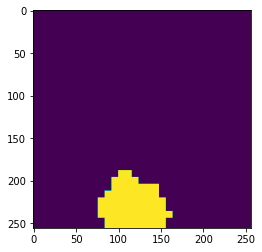

0.921875
0.0


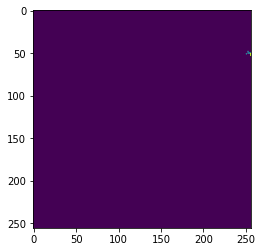

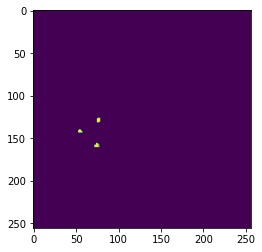

0.93359375
0.23557257390706599


In [0]:
from sklearn.metrics import recall_score, 

# batches = [next(gen()) for i in range(1)]
accuracies = []
recalls = []
for batch in batches:
  x, y = batch
  pred = model.predict(x, batch_size=16)
  for i in range(len(pred)):
    expected = np.reshape(y[i], (256, 256))
    actual = np.reshape(pred[i], (256, 256))
    actual = actual > actual.max() * 0.8
    acc = accuracy_score(expected, actual)
    rec = recall_score(np.reshape(expected, 256 * 256), np.reshape(actual, 256 * 256))
    recalls.append(rec)
    accuracies.append(score)
    print(acc)
    print(rec)
    plt.imshow(actual)
    plt.show()
    plt.imshow(expected)
    plt.show()

print(np.mean(accuracies))
print(np.mean(recalls))